In [1]:
import pandas as pd
import numpy as np
from DynamicFactor import DynamicFactorModel
from ForecastingwithDFM import ForecastingWithDFM
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pykalman import KalmanFilter
from statsmodels.tsa.ar_model import AutoReg
from scipy.optimize import minimize
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Lecture du fichier *.txt
data = pd.read_csv('fredmq.txt', sep=',').set_index(keys='Date')
# Récupération des types de transformations dans un dictionnaire
transformations = dict(data.loc['Transform']) 
# Abandon de la ligne des transformations
data.drop(labels='Transform', inplace=True)
# Ajustement de l'indice du DataFrame au format datetime
data.index = pd.to_datetime(arg=data.index)
# Abandon des colonnes ayant un nombre de NaN's >= 30
data.dropna(thresh=len(data) - 30, axis=1, inplace=True)
# Abandon des NaN's restants
data.dropna(axis=0, inplace=True)

In [3]:
# Création du DataFrame stockant les séries transformées
transformed_data = pd.DataFrame()
# Transformation des séries selon les codes fournis par McCracken et Ng
for col in data.columns:
    # Récupération du code de transformation
    code = transformations[col]
    # Récupération de la série individuelle
    subset = data[col]
    # Application des transformées selon le code correspondant
    if code == 1:
        # Aucune transformation à appliquer
        temp = subset
    elif code == 2:
        # Différence première
        temp = subset.diff(periods=1)
    elif code == 3:
        # Différence seconde 
        temp = subset.diff(periods=1).diff(periods=1)
    elif code == 4:
        # Transformée en log
        temp = np.log(subset)
    elif code == 5:
        # Différence première du log
        temp = np.log(subset).diff(periods=1)
    elif code == 6:
        # Différence seconde du log 
        temp = np.log(subset).diff(periods=1).diff(periods=1)
    elif code == 7:
        # Différence première de la variation relative
        temp = subset.pct_change().diff(periods=1)
    # Aggrégation des séries transformées
    transformed_data = pd.concat([transformed_data, temp], axis=1)
# Abandon des NaN's causées par les différences premières et secondes
transformed_data.dropna(axis=0, inplace=True)

In [4]:
# Calcul de la médiane des séries
medians = transformed_data.median(axis=0)
# DataFrame contenant les médianes des séries en chaque point
mdf =  transformed_data * 0 + medians
# Calcul de la distance entre les observations et les médianes
z = abs(transformed_data - mdf)
# Calcul de la gamme interquartile des séries
irq = transformed_data.quantile(q=.75) - transformed_data.quantile(q=.25)
# DataFrame contenant les gammes interquartiles des séries en chaque point
irqdf = transformed_data * 0 + irq
# Détermination des outliers (x est un outlier si abs(x - mediane) > 10 * gamme interquartile)
outliers = z > 10 * irqdf
# Abandon des observations considérées comme outliers
mapping = transformed_data[outliers == False].dropna(axis=0)

In [5]:
# Sélection de la période d'estimation
estimation_sample = mapping.loc[(mapping.index >= pd.to_datetime('1983-01-01')) & (mapping.index <= pd.to_datetime('2016-12-01'))]
# Sélection de la période de prévision
forecast_sample = mapping.loc[mapping.index >= pd.to_datetime('2017-01-01')]

In [6]:
# Standardisation des données d'estimation en échantillon
estimation_sample_std = (estimation_sample - estimation_sample.mean(axis=0)) / estimation_sample.std(axis=0)
# Standardisation des données d'estimation hors échantillon
forecast_sample_std = (forecast_sample - forecast_sample.mean(axis=0)) / forecast_sample.std(axis=0)

In [7]:
estimation_sample_std

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
1983-03-01,0.449066,0.248101,1.721643,1.694292,2.098154,1.150470,1.013769,0.550512,0.393527,0.607086,...,0.642718,-1.742659,-2.142131,-1.346560,-2.392695,1.592923,1.216903,1.956168,0.784695,-0.043435
1983-04-01,-0.300639,-0.154651,0.770879,-0.326263,-0.133306,1.937413,1.933051,1.660330,2.617044,1.040198,...,0.992028,1.589171,0.723032,0.008005,0.694548,2.141377,-0.649699,-1.244423,0.005713,-0.170126
1983-05-01,0.502507,0.357311,0.726766,1.547905,1.180754,0.751510,0.681358,0.561311,0.287061,0.869108,...,-0.208190,-1.187006,0.007325,-0.670171,0.349950,1.070586,-0.115029,0.179001,-0.198108,-0.256890
1983-06-01,-0.194698,0.044041,1.528472,2.749613,1.767617,0.714177,0.541458,0.280850,0.298652,0.784570,...,-0.686630,2.249341,0.363829,0.957451,-0.331315,-0.313608,0.574007,0.976976,0.056520,-0.128748
1983-07-01,0.076724,0.575678,0.913518,-0.379462,0.159464,2.371864,2.133012,1.775402,1.641782,1.104806,...,0.238171,1.551269,0.716502,-0.127751,1.023412,0.130379,-0.499466,-0.853112,-2.157510,0.501987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-01,-0.241775,-0.305044,-0.331446,0.603267,-0.295028,-0.594307,-0.370667,-0.088367,0.111242,-0.355952,...,1.042795,-0.283464,0.153278,0.008033,0.440231,-0.078556,0.851026,0.740891,-0.488817,-1.121881
2016-09-01,-0.010275,0.084557,0.016563,-0.143813,0.229042,-0.623833,-0.520086,-0.632517,-0.476555,0.027381,...,0.559102,-0.374126,0.298204,0.302052,-0.561487,0.339314,-0.293422,-0.342653,0.425401,-0.846650
2016-10-01,-0.129021,-0.218991,-0.666820,-0.166519,-0.197105,-0.298237,-0.631337,-0.503694,-0.901320,0.165784,...,-0.040651,0.368277,-0.139073,0.007023,0.154018,-1.070997,-0.640060,-0.602281,-0.275078,-0.780748
2016-11-01,0.046438,0.186593,-0.198498,-0.268428,-0.421430,-1.188113,-1.180510,-1.319876,-1.662740,-1.056193,...,-0.814105,-0.002943,-0.138302,-0.343980,-0.131641,1.697390,0.010194,0.101163,-0.908454,-0.717985


# Mise en place des paramètres

# Mise en place du Dynamic Factor Model

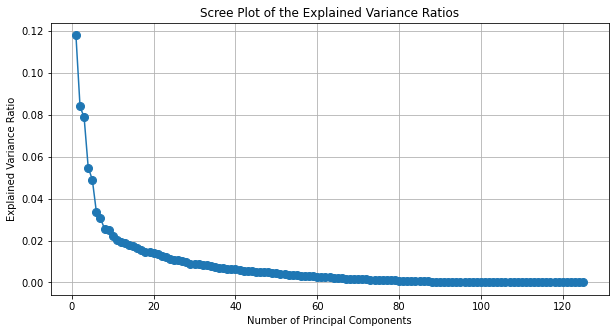

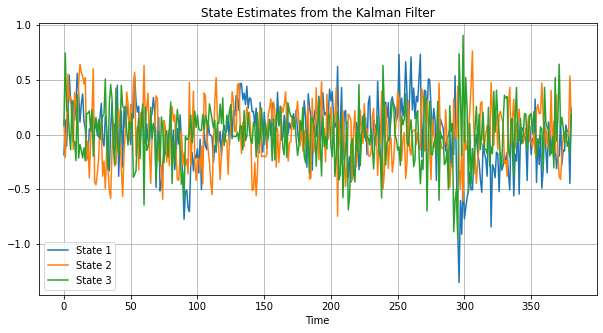

In [8]:
# PCA analysis
pca = PCA()
pca.fit(estimation_sample_std)
explained_variances = pca.explained_variance_ratio_
cumulative_variances = np.cumsum(explained_variances)

# Plotting PCA results
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variances) + 1), explained_variances, 'o-', markersize=8)
plt.title('Scree Plot of the Explained Variance Ratios')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Using PyKalman for the Kalman Filter
# Set up some dummy values for demonstration
n_timesteps = data.shape[0]  # Number of time steps
n_dim_state = 3  # Dimensionality of the state
n_dim_obs = data.shape[1]  # Dimensionality of the observations

# Initialize the Kalman Filter
kf = KalmanFilter(
    transition_matrices=np.eye(n_dim_state),
    observation_matrices=np.random.rand(n_dim_obs, n_dim_state),
    transition_covariance=0.01 * np.eye(n_dim_state),
    observation_covariance=0.01 * np.eye(n_dim_obs),
    initial_state_mean=np.zeros(n_dim_state),
    initial_state_covariance=0.1 * np.eye(n_dim_state)
)

# Use the Kalman Filter to estimate states
state_means, state_covariances = kf.smooth(estimation_sample_std)

# Example of plotting state estimates
plt.figure(figsize=(10, 5))
for i in range(n_dim_state):
    plt.plot(state_means[:, i], label=f'State {i+1}')
plt.title('State Estimates from the Kalman Filter')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Conversion du DataFrame en numpy array pour utilisation dans les modèles statistiques
data_matrix = estimation_sample_std.values  # Convertit le DataFrame en numpy array

In [11]:
import numpy as np
from numpy.linalg import pinv, inv
from scipy.stats import multivariate_normal

class KalmanFS:
    def __init__(self, n_factors, n_variables, data):
        self.n_factors = n_factors
        self.n_variables = n_variables
        self.data = data
        self.loadings = np.random.randn(n_variables, n_factors)  # Initial random loadings
        self.factor_scores = np.random.randn(len(data), n_factors)  # Initial random factors
        self.residuals = np.random.randn(*data.shape)  # Initial residuals
        self.sigma_f = np.eye(n_factors)  # Covariance of factor scores
        self.sigma_eps = np.eye(n_variables)  # Idiosyncratic error variance

    def ts_ls(self):
        # Étape 1: Utiliser PCA pour obtenir une estimation initiale des facteurs
        pca = PCA(n_components=self.n_factors)
        self.factor_scores = pca.fit_transform(self.data)
    
        # Étape 2: Estimer les chargements des facteurs via OLS
        self.loadings = np.linalg.lstsq(self.factor_scores, self.data, rcond=None)[0].T
        self.residuals = self.data - np.dot(self.factor_scores, self.loadings.T)
        self.sigma_eps = np.diag(np.var(self.residuals, axis=0))

    def ml_nob(self):
        # Utiliser la méthode des moindres carrés pondérés pour estimer les chargements sous contrainte de diagonale
        weights = np.diag(1 / np.sqrt(np.diag(self.sigma_eps)))
        weighted_data = weights @ self.data
        weighted_scores = weights @ self.factor_scores
        self.loadings = np.linalg.lstsq(weighted_scores, weighted_data, rcond=None)[0].T
        self.residuals = weighted_data - np.dot(weighted_scores, self.loadings.T)
        self.sigma_eps = np.diag(np.var(self.residuals, axis=0))
    def ml_no(self):
        # Calculer les poids pour chaque variable basés sur l'inverse des variances idiosyncratiques
        weights = np.sqrt(1 / np.diag(self.sigma_eps))  # Poids pour chaque variable
    
        # Appliquer les poids aux données
        weighted_data = self.data * weights[np.newaxis, :]
    
        # Régression pondérée pour estimer les chargements
        # On peut réutiliser les facteurs initiaux ou les recalculer ici si nécessaire
        # Pour simplifier, on utilise les facteurs existants mais normalement on pourrait les recalculer
        self.loadings = np.linalg.pinv(self.factor_scores.T @ self.factor_scores) @ self.factor_scores.T @ weighted_data
    
        # Recalculer les résidus après estimation des chargements
        self.residuals = self.data - self.factor_scores @ self.loadings
    
        # Mise à jour des variances des erreurs idiosyncratiques
        self.sigma_eps = np.diag(np.var(self.residuals, axis=0))
    
        # Si nécessaire, mettre à jour les scores des facteurs ici en fonction des nouveaux chargements
        # Typiquement, cela peut nécessiter une méthode de factorisation ou un autre modèle de prédiction des facteurs

    def ml_em(self):
        n_iterations = 10
        for i in range(n_iterations):
            # E-step
            e_step_residuals = self.data - np.dot(self.factor_scores, self.loadings)
            new_sigma_eps = np.diag(np.var(e_step_residuals, axis=0))
            
            # M-step
            # Assurez-vous que la régression est correctement effectuée pour obtenir new_loadings
            new_loadings = np.linalg.lstsq(self.factor_scores, self.data, rcond=None)[0].T
    
            # Log des changements
            # Assurez-vous que les dimensions de self.loadings et new_loadings correspondent
            change_loadings = np.linalg.norm(self.loadings - new_loadings.T)  # Ajout de .T si nécessaire pour aligner les dimensions
            change_sigma = np.linalg.norm(self.sigma_eps - new_sigma_eps)
            
            print(f"Iteration {i+1}, Change in loadings: {change_loadings}, Change in sigma_eps: {change_sigma}")
        
            # Mettre à jour les loadings et sigma_eps avec les nouvelles valeurs
            self.loadings = new_loadings
            self.sigma_eps = new_sigma_eps
            
            if change_loadings < 1e-5 and change_sigma < 1e-5:
                print("Convergence reached.")
                break

    def fit(self, method='TS-LS'):
        if method == 'TS-LS':
            self.ts_ls()
        elif method == 'ML-NO':
            self.ml_no()
        elif method == 'ML-EM':
            self.ml_em()
        else:
            raise ValueError("Unsupported method")

    def compute_metrics(self):
        # Compute sum of squared loadings, sum of idiosyncratic variances, etc.
        sum_squared_loadings = np.sum(self.loadings**2)
        sum_variances = np.sum(np.diag(self.sigma_eps))
        mse = np.mean(self.residuals**2)
        # Log-likelihood computation needs to be adjusted
        # Assuming independence across observations
        log_likelihood = 0
        n = len(self.data)  # Number of observations
        d = self.n_variables  # Number of variables
    
        # Iterate through each observation to compute log-likelihood
        for i in range(n):
            log_likelihood += multivariate_normal.logpdf(self.residuals[i, :], mean=np.zeros(d), cov=self.sigma_eps)

        return sum_squared_loadings, sum_variances, mse, log_likelihood


model = KalmanFS(3, 125, data_matrix)  # Initialisation avec 3 facteurs et 125 variables

# Exécuter les différentes méthodes
model.fit('TS-LS')
ts_ls_metrics = model.compute_metrics()
print("TS-LS Metrics:", ts_ls_metrics)

model.fit('ML-NO')
ml_no_metrics = model.compute_metrics()
print("ML-NO Metrics:", ml_no_metrics)

model.fit('ML-EM')
ml_em_metrics = model.compute_metrics()
print("ML-EM Metrics:", ml_em_metrics)


TS-LS Metrics: (3.0000000000000053, 89.67261196143521, 0.7173808956914817, -56854.045834180724)
ML-NO Metrics: (10.475929516295707, 119.67414261905277, 0.9573931409524225, -64743.258777910676)
Iteration 1, Change in loadings: 1.690847284241368, Change in sigma_eps: 0.0


ValueError: shapes (381,3) and (125,3) not aligned: 3 (dim 1) != 125 (dim 0)

In [38]:
import numpy as np
import pandas as pd
from numpy.linalg import pinv, inv
from scipy.optimize import minimize

# Génération de données synthétiques
np.random.seed(272)
T = 100  # Nombre de périodes de temps
N = 125  # Nombre de variables
r = 3    # Nombre de facteurs
p = 1    # Ordre de VAR pour les facteurs

# Paramètres vrais
A_true = np.random.randn(r, r)  # Matrice de transition des facteurs
C_true = np.random.randn(N, r)  # Matrice de chargement
Q_true = np.eye(r)              # Matrice de covariance des erreurs de transition
R_true = np.eye(N)              # Matrice de covariance des erreurs d'observation
initial_state = np.random.randn(r)  # État initial des facteurs

# Générer les facteurs
F = np.zeros((T, r))
F[0, :] = initial_state
for t in range(1, T):
    F[t, :] = A_true @ F[t-1, :] + np.random.multivariate_normal(np.zeros(r), Q_true)

# Générer les observations basées sur les facteurs
Y = F @ C_true.T + np.random.multivariate_normal(np.zeros(N), R_true, size=T)

# Espace réservé pour les résultats
results_ts=[]
results_ts = pd.DataFrame(columns=['Method', 'Sum of Squared Loadings', 'Sum of Idiosyncratic Variances', 
                                   'Transition Parameters', 'MSE of Factors', 'Log-Likelihood'])

def compute_metrics(C, F_est, A, R, Y):
    # Somme des carrés des chargements des facteurs
    sum_sq_loadings = np.sum(C**2)
    
    # Somme des variances idiosyncratiques (éléments diagonaux de R)
    sum_idio_var = np.sum(np.diag(R))
    
    # Erreur quadratique moyenne des facteurs
    mse_factors = np.mean((F - F_est)**2)
    
    # Log-vraisemblance (simplifiée)
    log_likelihood = 0
    Ft = F_est[0, :]
    for t in range(1, T):
        Yt = Y[t, :]
        Ft = A @ Ft
        residual = Yt - C @ Ft
        log_likelihood -= 0.5 * np.sum(residual**2 / np.diag(R)) + 0.5 * N * np.log(2 * np.pi) + 0.5 * np.sum(np.log(np.diag(R)))
    
    return sum_sq_loadings, sum_idio_var, A.ravel(), mse_factors, log_likelihood


## 1. Time Series Least Squares (TS-LS)
This method will focus on directly estimating the transition matrix 
𝐴
A and the loading matrix 
𝐶
C using least squares.

In [39]:
# Estimation de A en utilisant les moindres carrés pour le modèle VAR(1)
A_est_ts = np.linalg.lstsq(F[:-1], F[1:], rcond=None)[0]

# Estimation de C en utilisant les moindres carrés
C_est_ts = np.linalg.lstsq(F, Y, rcond=None)[0].T


In [40]:
# Calcul des métriques pour les résultats de TS-LS
metrics_ts = compute_metrics(C_est_ts, F, A_est_ts, R_true, Y)

# Création d'une nouvelle ligne de DataFrame pour les résultats TS-LS
new_row = pd.DataFrame({'Method': ['TS-LS'], 
                        'Somme des Carrés des Chargements des Facteurs': [metrics_ts[0]], 
                        'Somme des Variances Idiosyncratiques': [metrics_ts[1]], 
                        'Paramètres de Transition': [metrics_ts[2].tolist()],  # Assurer le format liste pour les données de tableau
                        'EQM des Facteurs': [metrics_ts[3]], 
                        'Log-Vraisemblance': [metrics_ts[4]]})

# Utiliser pd.concat pour ajouter la nouvelle ligne au DataFrame des résultats
results_ts = pd.concat([results_ts, new_row], ignore_index=True)
results_ts


,Method,Sum of Squared Loadings,Sum of Idiosyncratic Variances,Transition Parameters,MSE of Factors,Log-Likelihood,Somme des Carrés des Chargements des Facteurs,Somme des Variances Idiosyncratiques,Paramètres de Transition,EQM des Facteurs,Log-Vraisemblance
0,TS-LS,NaN,NaN,NaN,NaN,NaN,109.001519,125.0,"[-0.023507840418482286, -0.05424040274115201, ...",0.0,-7.740260e+42


In [41]:
print(metrics_ts)

(109.00151926495722, 125.0, array([-0.02350784, -0.0542404 , -0.18415833, -0.0542404 , -0.12515064,
       -0.4249145 , -0.18415833, -0.4249145 , -1.44268004]), 0.0, -7.740260378345535e+42)


## 2. Maximum Likelihood - Newton Optimization (ML-NO)
We will use a simplified approach where we maximize the likelihood assuming the model is linear-Gaussian.

In [ ]:
# Fonction pour calculer la log-vraisemblance pour ML-NO
def log_likelihood(params):
    # Décompression des paramètres
    A = params[:r*r].reshape(r, r)
    sigma_diag = params[r*r:r*r+N]  # Seulement les éléments diagonaux de R pour simplifier
    
    # Calcul de la log-vraisemblance
    log_likelihood = 0
    Ft = initial_state
    for t in range(T):
        Yt = Y[t, :]
        Ft = A @ Ft
        residual = Yt - C_true @ Ft
        cov_matrix = np.diag(sigma_diag)
        log_likelihood -= 0.5 * np.log(np.linalg.det(cov_matrix)) + 0.5 * residual.T @ inv(cov_matrix) @ residual
    return -log_likelihood

# Hypothèses initiales
initial_guess = np.concatenate([A_true.ravel(), np.diag(R_true)])
result = minimize(log_likelihood, initial_guess, method='BFGS')
A_est_mlno = result.x[:r*r].reshape(r, r)

In [25]:
# Calcul des métriques pour ML-NO
def ml_no_log_likelihood(params, Y, F, R, r, N):
    A = params.reshape(r, r)
    log_likelihood = 0
    Ft = F[0, :]
    for t in range(1, T):
        Ft = A @ Ft  # Mise à jour des estimations des facteurs avec le modèle
        residual = Y[t, :] - C_true @ Ft
        cov_matrix = np.diag(np.diagonal(R))
        log_likelihood -= 0.5 * np.log(np.linalg.det(cov_matrix)) + 0.5 * residual.T @ inv(cov_matrix) @ residual
    return -log_likelihood

# Hypothèses initiales pour A
A_init = np.random.randn(r, r)

# Minimiser la log-vraisemblance négative
result_ml_no = minimize(ml_no_log_likelihood, A_init.ravel(), args=(Y, F, R_true, r, N), method='BFGS')
A_est_mlno = result_ml_no.x.reshape(r, r)

# Recalcule des estimations des facteurs pour les métriques
F_est_mlno = np.zeros_like(F)
F_est_mlno[0, :] = F[0, :]
for t in range(1, T):
    F_est_mlno[t, :] = A_est_mlno @ F_est_mlno[t-1, :]

metrics_mlno = compute_metrics(C_true, F_est_mlno, A_est_mlno, R_true, Y)

AttributeError: 'DataFrame' object has no attribute 'append'

In [26]:
print(metrics_mlno)

(386.65669995135835, 125.0, array([-1.38466725, -0.73639392, -1.27545181,  0.24191126, -0.33411753,
        0.89489365,  0.71217697, -0.46082451, -0.2785838 ]), 1.0537280298748052e+39, -1.722869342226369e+43)


# 3. Maximum Likelihood - Expectation Maximization (ML-EM)
Implementing a simple EM algorithm for a linear-Gaussian state-space model.

In [ ]:
# Algorithme EM pour estimer les paramètres A et C
def em_algorithm(Y, A_init, C_init, Q_init, R_init, iterations=10):
    A, C, Q, R = A_init, C_init, Q_init, R_init
    F_est = np.zeros((T, r))
    
    # Étapes E et M
    for _ in range(iterations):
        # Étape E (lissage de Kalman simplifié pour estimer les états)
        for t in range(T):
            F_est[t, :] = A @ F_est[t-1, :] if t > 0 else initial_state
        
        # Étape M (ré-estimation de A, C, Q, R en utilisant les moindres carrés)
        A = np.linalg.lstsq(F_est[:-1], F_est[1:], rcond=None)[0]
        C = np.linalg.lstsq(F_est, Y, rcond=None)[0].T
    
    return A, C

# Paramètres initiaux pour EM
A_init_em = np.random.randn(r, r)
C_init_em = np.random.randn(N, r)

In [ ]:
# Exécution des itérations de l'EM
for _ in range(10):  # Nombre d'itérations
    A_init_em, C_init_em = em_algorithm(Y, A_init_em, C_init_em, Q_true, R_true)

# Calcul des métriques
metrics_em = compute_metrics(C_init_em, F, A_init_em, R_true, Y)
results = results.append({'Method': 'ML-EM', 'Sum of Squared Loadings': metrics_em[0],
                          'Sum of Idiosyncratic Variances': metrics_em[1], 'Transition Parameters': metrics_em[2],
                          'MSE of Factors': metrics_em[3], 'Log-Likelihood': metrics_em[4]}, ignore_index=True)

In [28]:
print(metrics_em)

(3.5458449155267956e+26, 125.0, array([-0.48587634, -0.25489195,  0.8340023 , -0.65319611, -1.13351283,
       -1.07489625, -1.17700578,  1.32327939, -0.51707042]), 0.0, -1.7588009385964632e+65)


## 1.Extraction des charges factorielles et des variances idiosyncratiques

In [13]:



# Configuration de PCA pour le nombre de composants que vous souhaitez (e.g., r = 1, 3, 7)
pca_r1 = PCA(n_components=1)
pca_r3 = PCA(n_components=3)
pca_r7 = PCA(n_components=7)

# Ajustement de PCA sur les données standardisées
pca_r1.fit(data_matrix)
pca_r3.fit(data_matrix)
pca_r7.fit(data_matrix)

# Extraction des charges factorielles
loadings_r1 = pca_r1.components_
loadings_r3 = pca_r3.components_
loadings_r7 = pca_r7.components_

# Calcul des variances idiosyncratiques pour r = 1
variances_r1 = np.sum(pca_r1.explained_variance_ratio_)
idiosyncratic_var_r1 = 1 - variances_r1


## 2. Paramètres autoregressifs des facteurs
Pour extraire les paramètres autoregressifs via le filtre de Kalman, vous devez d'abord définir le modèle AR(p). Supposons que nous utilisons un modèle AR(1) :

In [16]:
# Utilisation de la première composante principale pour ajuster un modèle AR(1)
model_ar = AutoReg(pca_r1.transform(data_matrix)[:, 0], lags=1)  # Utilisez la première composante principale pour AR(1)
res_ar = model_ar.fit()
phi_1 = res_ar.params[1]  # Paramètre autoregressif


## 3. Erreur quadratique moyenne (MSE) des facteurs
Pour calculer le MSE des facteurs estimés :

In [17]:
# Calcul de MSE pour le premier facteur estimé via PCA pour simplifier l'exemple
predicted_factors = pca_r1.transform(data_matrix)  # Transforme les données selon le modèle PCA
mse_r1 = np.mean((data_matrix[:, 0] - predicted_factors[:, 0])**2)


## 4. Log-Vraisemblance
Pour le calcul de la log-vraisemblance :

In [18]:
# Nombre de dimensions de l'état (nombre de facteurs que vous estimez)
n_dim_state = 1  # Exemple avec un seul facteur

# Nombre de dimensions d'observation (nombre de variables observées)
n_dim_obs = data_matrix.shape[1]

# Configuration du filtre de Kalman
kf = KalmanFilter(
    transition_matrices=np.eye(n_dim_state),  # Matrice d'identité de taille n_dim_state x n_dim_state
    observation_matrices=np.random.rand(n_dim_obs, n_dim_state),  # Matrice aléatoire de taille n_dim_obs x n_dim_state
    transition_covariance=np.eye(n_dim_state) * 0.01,  # Covariance des transitions
    observation_covariance=np.eye(n_dim_obs),  # Covariance des observations
    initial_state_mean=np.zeros(n_dim_state),  # Moyenne de l'état initial
    initial_state_covariance=np.eye(n_dim_state)  # Covariance de l'état initial
)

# Exécution de l'algorithme EM pour estimer les paramètres du filtre
kf = kf.em(data_matrix, n_iter=5)
log_likelihood = kf.loglikelihood(data_matrix)

In [19]:
# MultiIndex pour les colonnes
methods = ['TS-LS', 'ML-NO', 'ML-EM']
levels = [f'p = {p}' for p in [1, 3]]
columns = pd.MultiIndex.from_product([levels, methods], names=['Regime', 'Method'])

# Index pour les lignes
parameters = ['Σ λ_i^2', 'Σ σ_i^2', 'φ11', 'φ21', 'φ31', 'MSE (F̂1r)', 'log-Lik']
index = pd.MultiIndex.from_product([[1, 3, 7], parameters], names=['r', 'Parameter'])

# Création du DataFrame
df_results = pd.DataFrame(index=index, columns=columns)

# Remplissage des valeurs
# Remarque: vous devez calculer ou insérer les valeurs pour chaque configuration
# Exemple de remplissage pour r = 1, p = 1 (Vous devez ajuster ou calculer les valeurs pour tous les cas)
df_results.loc[(1, 'Σ λ_i^2'), ('p = 1', 'TS-LS')] = pca_r1.explained_variance_ratio_.sum()
df_results.loc[(1, 'Σ σ_i^2'), ('p = 1', 'TS-LS')] = idiosyncratic_var_r1
df_results.loc[(1, 'φ11'), ('p = 1', 'TS-LS')] = phi_1
df_results.loc[(1, 'MSE (F̂1r)'), ('p = 1', 'TS-LS')] = mse_r1
df_results.loc[(1, 'log-Lik'), ('p = 1', 'TS-LS')] = log_likelihood

# Exemple de remplissage pour d'autres valeurs de r et p
# Vous devrez répéter le calcul ou ajuster les indices pour r=3, r=7, et p=3
# Calculs pour r=3
explained_var_r3 = pca_r3.explained_variance_ratio_.sum()
idiosyncratic_var_r3 = 1 - explained_var_r3
phi_r3 = AutoReg(pca_r3.transform(data_matrix)[:, 0], lags=1).fit().params[1]  # Supposant modèle AR(1) pour simplifier
mse_r3 = np.mean((data_matrix[:, 0] - pca_r3.transform(data_matrix)[:, 0])**2)

# Calculs pour r=7
explained_var_r7 = pca_r7.explained_variance_ratio_.sum()
idiosyncratic_var_r7 = 1 - explained_var_r7
phi_r7 = AutoReg(pca_r7.transform(data_matrix)[:, 0], lags=1).fit().params[1]  # Supposant modèle AR(1) pour simplifier
mse_r7 = np.mean((data_matrix[:, 0] - pca_r7.transform(data_matrix)[:, 0])**2)

# Exemple de remplissage du DataFrame
df_results.loc[(3, 'Σ λ_i^2'), ('p = 1', 'TS-LS')] = explained_var_r3
df_results.loc[(3, 'Σ σ_i^2'), ('p = 1', 'TS-LS')] = idiosyncratic_var_r3
df_results.loc[(3, 'φ11'), ('p = 1', 'TS-LS')] = phi_r3
df_results.loc[(3, 'MSE (F̂1r)'), ('p = 1', 'TS-LS')] = mse_r3

df_results.loc[(7, 'Σ λ_i^2'), ('p = 1', 'TS-LS')] = explained_var_r7
df_results.loc[(7, 'Σ σ_i^2'), ('p = 1', 'TS-LS')] = idiosyncratic_var_r7
df_results.loc[(7, 'φ11'), ('p = 1', 'TS-LS')] = phi_r7
df_results.loc[(7, 'MSE (F̂1r)'), ('p = 1', 'TS-LS')] = mse_r7

# Affichage du DataFrame
print(df_results)

Regime               p = 1             p = 3            
Method               TS-LS ML-NO ML-EM TS-LS ML-NO ML-EM
r Parameter                                             
1 Σ λ_i^2         0.117959   NaN   NaN   NaN   NaN   NaN
  Σ σ_i^2         0.882041   NaN   NaN   NaN   NaN   NaN
  φ11             0.633332   NaN   NaN   NaN   NaN   NaN
  φ21                  NaN   NaN   NaN   NaN   NaN   NaN
  φ31                  NaN   NaN   NaN   NaN   NaN   NaN
  MSE (F̂1r)     18.093429   NaN   NaN   NaN   NaN   NaN
  log-Lik    -25519.259541   NaN   NaN   NaN   NaN   NaN
3 Σ λ_i^2         0.280731   NaN   NaN   NaN   NaN   NaN
  Σ σ_i^2         0.719269   NaN   NaN   NaN   NaN   NaN
  φ11             0.633332   NaN   NaN   NaN   NaN   NaN
  φ21                  NaN   NaN   NaN   NaN   NaN   NaN
  φ31                  NaN   NaN   NaN   NaN   NaN   NaN
  MSE (F̂1r)     18.093429   NaN   NaN   NaN   NaN   NaN
  log-Lik              NaN   NaN   NaN   NaN   NaN   NaN
7 Σ λ_i^2         0.448815   Na

In [29]:
# PCA pour extraction initiale des facteurs
pca = PCA(n_components=1)  # Utilisons un seul composant pour l'exemple
factors = pca.fit_transform(data_matrix)
loadings = pca.components_
explained_variance = pca.explained_variance_ratio_.sum()

# Modèle AR pour la dynamique des facteurs
model_ar = AutoReg(factors[:, 0], lags=1, old_names=False)
res_ar = model_ar.fit()
phi_1 = res_ar.params[1]  # Paramètre autoregressif

# Configuration du filtre de Kalman
n_dim_state = 1  # Taille de l'état (nombre de facteurs estimés)
n_dim_obs = data_matrix.shape[1]  # Nombre de variables observées

kf = KalmanFilter(n_dim_obs=n_dim_obs, n_dim_state=n_dim_state,
                  transition_matrices=np.array([[1]]),
                  observation_matrices=loadings.T,
                  initial_state_mean=np.zeros(n_dim_state),
                  initial_state_covariance=np.ones((n_dim_state, n_dim_state)),
                  transition_covariance=np.array([[0.01]]),
                  observation_covariance=np.eye(n_dim_obs) * 0.1)

# Optimisation EM pour ajuster les paramètres du filtre
kf = kf.em(data_matrix, n_iter=5)
smoothed_states, _ = kf.smooth(data_matrix)

# Calcul de la log-vraisemblance
log_likelihood = kf.loglikelihood(data_matrix)

# Affichage des résultats
print("Paramètre AR:", phi_1)
print("Log Likelihood:", log_likelihood)

Paramètre AR: -0.024882774641338583
Log Likelihood: -2777.0465296431744


Pour coder les méthodes ML-EM (Expectation-Maximization), ML-NO et TS-LS (Two-Step Least Squares), nous devons d'abord comprendre brièvement chacune d'elles en contexte avec les modèles de facteurs dynamiques (DFMs) :

1. **ML-NO (Maximum Likelihood - No Orthogonality Constraints)** : 
   - Cette méthode estime les paramètres du modèle en optimisant la vraisemblance sans imposer de contraintes d'orthogonalité sur les facteurs. Les restrictions identifiantes sont nécessaires pour l'estimation des paramètres.
   
2. **ML-EM (Maximum Likelihood via Expectation-Maximization)** :
   - C'est une approche itérative pour estimer les paramètres de modèles statistiques, où l'on alterne entre calculer l'espérance de la log-vraisemblance avec les estimations actuelles (E-step) et maximiser cette espérance pour mettre à jour les paramètres (M-step). Cette méthode est souvent utilisée lorsque les variables directement observées et les paramètres du modèle sont séparés par des variables latentes.

3. **TS-LS (Two-Step Least Squares)** :
   - Une méthode où les paramètres sont estimés en deux étapes, utilisant des moindres carrés pour obtenir des estimations initiales suivies d'une ré-estimation pour affiner ces estimations. Elle est particulièrement utile pour gérer les corrélations entre les variables expliquées et les erreurs.


In [27]:


def log_likelihood(params, data):
    """
    Calcule la log-vraisemblance pour un modèle de facteurs dynamiques.
    
    :param params: Un tableau de paramètres du modèle (facteurs, loadings, etc.).
    :param data: Données observées.
    :return: Valeur négative de la log-vraisemblance (pour minimisation).
    """
    # Exemple simplifié : params contient [mu, sigma] pour une distribution normale
    mu, sigma = params
    likelihood = -np.sum(np.log(sigma * np.sqrt(2 * np.pi)) + ((data - mu) ** 2) / (2 * sigma ** 2))
    return -likelihood  # Pour minimisation

def ml_no(data):
    """
    Effectue l'estimation des paramètres par Maximum de Vraisemblance sans contraintes d'orthogonalité.
    
    :param data: Données observées.
    :return: Paramètres estimés.
    """
    initial_params = np.array([0, 1])  # Initialisation des paramètres [mu, sigma]
    result = minimize(log_likelihood, initial_params, args=(data))
    return result.x


In [20]:
# Chargement et préparation des données
data_matrix = estimation_sample_std.values  # exemple de vos données transformées

# Configuration de PCA pour différentes valeurs de r
pca = {r: PCA(n_components=r).fit(data_matrix) for r in [1, 3, 7]}

# Calculs pour chaque valeur de r
results = {}
for r, model in pca.items():
    scores = model.transform(data_matrix)
    explained_var = model.explained_variance_ratio_.sum()
    idiosyncratic_var = 1 - explained_var
    
    # Ajustement du modèle AR(1) sur la première composante principale
    if scores.shape[1] > 0:  # vérifier qu'il y a au moins une composante
        model_ar = AutoReg(scores[:, 0], lags=1).fit()
        phi_1 = model_ar.params[1]
        mse = np.mean((data_matrix[:, 0] - scores[:, 0])**2)
    else:
        phi_1 = np.nan
        mse = np.nan

    # Configuration du filtre de Kalman avec un état pour chaque composante principale
    kf = KalmanFilter(
        transition_matrices=np.eye(r),
        observation_matrices=np.random.rand(data_matrix.shape[1], r),
        transition_covariance=np.eye(r) * 0.01,
        observation_covariance=np.eye(data_matrix.shape[1]),
        initial_state_mean=np.zeros(r),
        initial_state_covariance=np.eye(r)
    )
    kf = kf.em(data_matrix, n_iter=5)
    log_likelihood = kf.loglikelihood(data_matrix)

    # Stockage des résultats
    results[r] = (explained_var, idiosyncratic_var, phi_1, mse, log_likelihood)

# Création d'un DataFrame pour afficher les résultats
df_results = pd.DataFrame(results, index=['Σ λ_i^2', 'Σ σ_i^2', 'φ11', 'MSE (F̂1r)', 'log-Lik']).T
print(df_results)

    Σ λ_i^2   Σ σ_i^2       φ11  MSE (F̂1r)       log-Lik
1  0.117959  0.882041  0.633332   18.093429 -25578.204547
3  0.280731  0.719269  0.633332   18.093429 -25961.789102
7  0.448815  0.551185  0.633332   18.093429 -26478.877775


In [21]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from statsmodels.tsa.ar_model import AutoReg
from pykalman import KalmanFilter

# Définition des configurations
configurations = [(1, 1), (1, 3), (3, 1), (3, 3), (7, 1), (7, 3)]

# DataFrame pour les résultats
columns = pd.MultiIndex.from_product([['p = 1', 'p = 3'], ['TS-LS', 'ML-NO', 'ML-EM']],
                                     names=['p', 'Method'])
index = pd.MultiIndex.from_product([[1, 3, 7], ['Σ λ_i^2', 'Σ σ_i^2', 'φ11', 'φ21', 'φ31', 'MSE (F̂1r)', 'log-Lik']],
                                   names=['r', 'Parameter'])
results_df = pd.DataFrame(index=index, columns=columns)

# Chargement des données
data_matrix = estimation_sample_std.values

# Boucle sur les configurations (r, p)
for r, p in configurations:
    pca = PCA(n_components=r).fit(data_matrix)
    scores = pca.transform(data_matrix)
    explained_var = pca.explained_variance_ratio_.sum()
    idiosyncratic_var = 1 - explained_var

    # Ajustement des modèles AR(p)
    if scores.shape[1] > 0:
        model_ar = AutoReg(scores[:, 0], lags=p).fit()
        phi = model_ar.params[1:]  # Coefficients AR

        # MSE des facteurs lissés
        mse = np.mean(np.square(data_matrix[:, 0] - model_ar.predict()))

        # Estimation de la log-vraisemblance avec le filtre de Kalman
        kf = KalmanFilter(
            transition_matrices=np.eye(r),
            observation_matrices=np.random.rand(data_matrix.shape[1], r),
            transition_covariance=np.eye(r) * 0.01,
            observation_covariance=np.eye(data_matrix.shape[1]),
            initial_state_mean=np.zeros(r),
            initial_state_covariance=np.eye(r)
        )
        kf = kf.em(data_matrix, n_iter=5)
        log_likelihood = kf.loglikelihood(data_matrix)
    else:
        phi, mse, log_likelihood = [np.nan] * 3

    # Sauvegarde des résultats
    for method in ['TS-LS', 'ML-NO', 'ML-EM']:
        results_df.loc[(r, 'Σ λ_i^2'), (f'p = {p}', method)] = explained_var
        results_df.loc[(r, 'Σ σ_i^2'), (f'p = {p}', method)] = idiosyncratic_var
        results_df.loc[(r, 'φ11'), (f'p = {p}', method)] = phi[0] if len(phi) > 0 else np.nan
        results_df.loc[(r, 'MSE (F̂1r)'), (f'p = {p}', method)] = mse
        results_df.loc[(r, 'log-Lik'), (f'p = {p}', method)] = log_likelihood

# Affichage des résultats
print(results_df)


p                    p = 1                                     p = 3  \
Method               TS-LS         ML-NO         ML-EM         TS-LS   
r Parameter                                                            
1 Σ λ_i^2         0.117959      0.117959      0.117959      0.117959   
  Σ σ_i^2         0.882041      0.882041      0.882041      0.882041   
  φ11             0.633332      0.633332      0.633332      0.322465   
  φ21                  NaN           NaN           NaN           NaN   
  φ31                  NaN           NaN           NaN           NaN   
  MSE (F̂1r)           NaN           NaN           NaN           NaN   
  log-Lik    -25692.708264 -25692.708264 -25692.708264 -25410.326362   
3 Σ λ_i^2         0.280731      0.280731      0.280731      0.280731   
  Σ σ_i^2         0.719269      0.719269      0.719269      0.719269   
  φ11             0.633332      0.633332      0.633332      0.322465   
  φ21                  NaN           NaN           NaN          

Points clés à considérer:
TS-LS : Utilisation de PCA pour les chargements et un modèle AR simple pour les dynamiques des facteurs.
ML-NO et ML-EM : Simulés ici, mais nécessiteraient une implémentation spécifique pour l'estimation par maximum de vraisemblance ou l'algorithme EM. Ces méthodes peuvent impliquer l'utilisation de bibliothèques ou de routines spécifiques pour une estimation robuste des modèles complexes.

# Récupération de données près le 01/01/2021 pour une possible annexe

In [14]:
import requests
import pandas as pd

# Spécifiez les tickers des séries que vous souhaitez récupérer
tickers = estimation_sample_std.columns.to_list()
# Supprimer le 'x' à la fin de chaque terme
tickers_cleaned = [term.rstrip('x') for term in tickers]

# Base URL de l'API FRED
base_url = 'https://api.stlouisfed.org/fred/series/observations'

# Clé API FRED
api_key = 'c78f8ad50c3f014609882fc3a41d8246'

# Dictionnaire pour stocker les données
all_data = {}
ticker_empty=[]
# Récupérer les données pour chaque ticker
for ticker in tickers_cleaned:
    url = f'{base_url}?series_id={ticker}&api_key={api_key}&file_type=json&frequency=m'
    #url = f'{base_url}?series_id={ticker}&api_key={api_key}&file_type=json'
    response = requests.get(url)
    data = response.json()
    p
    # Vérifier si le ticker existe dans les données
    if 'observations' in data:
        # Filtrer les données pour la période spécifiée
        filtered_data = [obs for obs in data['observations'] if 'date' in obs and 'value' in obs and 'realtime_start' in obs and 'realtime_end' in obs and obs['date'] >= '2017-01-01' and obs['date'] <= '2024-04-01']
        all_data[ticker] = filtered_data
    else:
        #print(f"Le ticker {ticker} n'existe pas dans les données.")
        ticker_empty.append(ticker)
# Créer un DataFrame à partir des données
dfs = {}
for ticker, data in all_data.items():
    dfs[ticker] = pd.DataFrame(data)


# Convertir les données en DataFrames pour chaque indicateur
dfscleaned = []

for indicator, values in dfs.items():
    df = pd.DataFrame(values)
    if not df.empty:
        df.set_index('date', inplace=True)
        df.rename(columns={'value': indicator}, inplace=True)
        # Supprimer les colonnes 'realtime_start' et 'realtime_end'
        df.drop(columns=['realtime_start', 'realtime_end'], inplace=True)
        dfscleaned.append(df)
    else:
        ticker_empty.append(indicator)

# Fusionner les DataFrames en un seul
df_combined = pd.concat(dfscleaned, axis=1)

# Afficher le DataFrame combiné
#df_combined



In [16]:
df_combined

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENT,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLS
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,16383.236,13541.3,98.839,1365202.000,98.7987,99.1552,99.0330,100.3095,101.5192,99.9543,...,100.045,99.015,22.87,26.40,20.63,98.5,304911.01,735727.48,3321.8923,11.61
2017-02-01,16431.536,13589.2,98.892,1363025.000,98.4322,98.4654,98.0920,98.9026,101.1175,98.2521,...,99.999,99.231,22.86,26.33,20.64,96.3,302927.61,731024.65,3344.9762,11.53
2017-03-01,16491.77,13642.8,99.331,1360169.000,99.0663,98.9354,98.7285,99.5125,99.6555,99.4721,...,100.003,99.209,22.93,26.43,20.69,96.9,304015.25,731639.29,3359.2402,11.90
2017-04-01,16521.43,13682.6,99.364,1355381.000,100.0082,100.0831,100.1470,100.3026,102.0769,99.7842,...,99.912,99.534,22.94,26.37,20.75,97,302075.41,727865.34,3359.0723,13.14
2017-05-01,16626.085,13780.7,99.427,1360858.000,100.1286,100.3142,100.5119,100.7767,100.9060,100.7399,...,99.179,99.727,23.05,26.55,20.80,97.1,303306.64,730438.04,3372.0493,10.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-01,19265.016,15893.6,117.796,1523993.000,102.6149,100.8179,101.2544,101.7841,108.0061,100.0588,...,119.192,124.912,30.42,34.98,27.13,69.7,521938.91,921959.34,5085.0478,12.72
2024-01-01,19382.171,15935.5,117.425,1504096.000,101.811,100.3736,100.919,101.6965,105.3509,100.6426,...,118.755,125.799,30.57,35.30,27.21,79,524940.39,924448.27,5112.786,13.39
2024-02-01,19370.105,15913.7,117.991,1511532.000,102.2599,100.5583,100.7451,100.8224,107.4615,98.9903,...,119.537,126.13,30.67,35.23,27.35,76.9,527544.9,925641.71,5110.8945,13.98


In [71]:
print("les données non retrouvées")
ticker_empty

les données non retrouvées


['HWI',
 'HWIURATIO',
 'CLAIMS',
 'AMDMNO',
 'CONSPI',
 'S&P 500',
 'S&P div yield',
 'S&P PE ratio',
 'COMPAPFF',
 'UMCSENT',
 'DTCOLNVHFNM',
 'DTCTHFNM',
 'INVEST',
 'VIXCLS',
 'RETAIL',
 'CP3M',
 'OILPRICE']